# LAB 06.02 - NMF face search

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()


replicating local resources


In [16]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L06.02", varname="student");

logging in as andres.lema1@udea.edu.co... please wait

-------------
using course session ai4eng.v1.udea.r3::2025.2
success!! you are logged in
-------------


## Dataset

we will use the faces dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:

import numpy as np
faces = np.load("local/data/faces.npy")
faces.shape


(535, 361)

In [5]:
def plot_faces(faces):
    assert len(faces)<=30, "can only plot at most 30 faces"
    plt.figure(figsize=(15,2))
    for i in range(len(faces)):
        plt.subplot(2,15,i+1)
        plt.imshow(faces[i].reshape(19,19), cmap=plt.cm.Greys_r)
        plt.xticks([]); plt.yticks([])

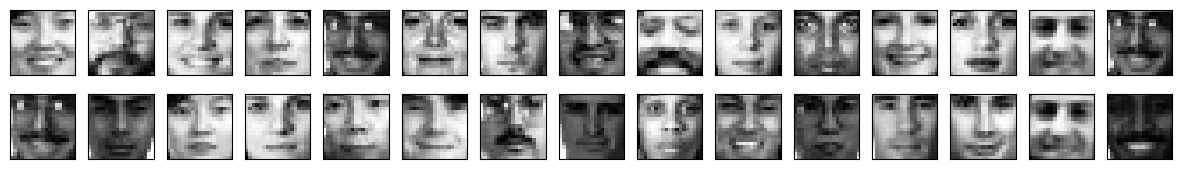

In [6]:

plot_faces(np.random.permutation(faces)[:30])


## Task 1: Distance function for a vector

complete the following function so that given a vector $v \in \mathbb{R}^n$ and a `numpy` array $X \in \mathbb{R}^{m\times n}$ (whose rows are vectors of the same size as $v$) returns a new array $\in \mathbb{R}^m$ with the Euclidean distance between $v$ and each vector in $X$.

Recall that the Euclidean distance between vectors $z=[z_0,...z_{n-1}]$ and $w=[w_0,...,w_{n-1}]$ is given by

$$\text{distance}(z,w) = \sqrt{\sum_{i=0}^{n-1} (z_i-w_i)^2}$$


**hint**: use [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) to compute a distance between two vectors

**challenge**: solve it using one line of code.

**note**: your function must return a 1D numpy array of dimension $m$, not a list.

for instance, for the following values of $v$ and $X$

    X = array([[9, 5, 1, 3, 8, 3, 3, 3, 9, 2],
               [9, 7, 0, 7, 9, 1, 4, 7, 3, 6],
               [8, 0, 0, 5, 0, 5, 5, 1, 1, 5],
               [8, 2, 9, 5, 6, 0, 8, 7, 2, 8],
               [0, 6, 3, 0, 6, 6, 1, 2, 8, 0]])
                  
    v = np.array([9, 7, 0, 7, 9, 1, 4, 7, 3, 6])


you should get the following result

    array([ 9.74679434,  0.        , 13.89244399, 11.91637529, 16.40121947])


In [7]:
def distances(v, X):
    result = np.linalg.norm(X - v, axis=1)
    return result

check manually your code

In [8]:
X = np.random.randint(10, size=(5,10))
v = X[1]

print ("X=\n", X)
print ("\nv=", v)
distances(v, X)

X=
 [[5 4 9 6 6 4 9 7 8 5]
 [9 2 0 8 8 2 2 1 7 9]
 [5 9 3 8 8 5 4 9 8 4]
 [1 0 5 9 0 5 3 6 3 6]
 [8 0 8 5 2 8 4 5 7 0]]

v= [9 2 0 8 8 2 2 1 7 9]


array([14.6628783 ,  0.        , 13.3041347 , 14.76482306, 15.84297952])

**submit your code**

In [9]:
student.submit_task(globals(), task_id="task_01");

## Task 2: Positions of closest vectors

complete the following function so that given $v$ and $X$ as previously, returns the positions of the $n$ closest vectors to $v$ in $X$.

**hint**: use the [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) function

**challenge**: solve it using one line of code

for the example $v$ and $X$ above you should get the following outputs

    >> closest(v, X, 2)
    array([1, 0])

    >> closest(v, X, 3)
    array([1, 0, 3])


In [18]:
def closest(v, X, n):
    assert n < len(X), "n must at most the number of vectors in X"
    dists = np.linalg.norm(X - v, axis=1)
    result = np.argsort(dists)[:n]
    return result

check manually your code

In [19]:
X = np.random.randint(10, size=(5,10))
v = X[1]

print ("X=\n", X)
print ("\nv=", v,"\n\n")
print (closest(v, X, 2))
print (closest(v, X, 3))

X=
 [[6 8 6 8 4 2 9 6 2 5]
 [1 2 7 3 2 6 8 0 6 5]
 [1 9 7 0 5 7 7 8 2 6]
 [3 2 9 8 7 8 2 6 6 1]
 [6 0 2 6 9 9 9 3 9 0]]

v= [1 2 7 3 2 6 8 0 6 5] 


[1 2]
[1 2 3]


### observe now how we can use your functions to search for faces similar to any other face

TARGET FACE


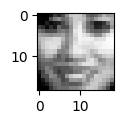

In [20]:

plt.figure(figsize=(1,1))
fi = 314 # np.random.randint(len(faces)) # 314
face = faces[fi]
plt.imshow(faces[fi].reshape(19,19), cmap=plt.cm.Greys_r)
print ("TARGET FACE")


SIMILAR FACES


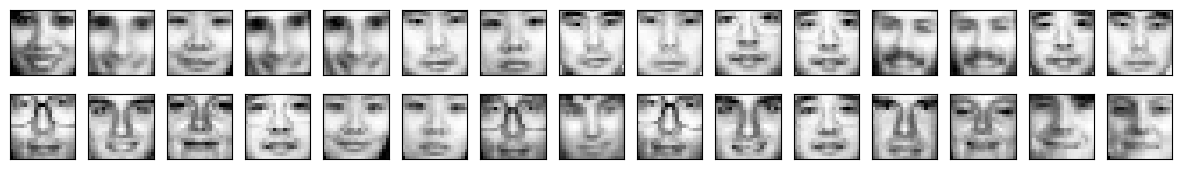

In [21]:

plot_faces(faces[closest(face, faces, 30)])
print ("SIMILAR FACES")


But they do not look so similar, this is because we are doing comparison **pixel by pixel**. We will fix this in the next task

**submit your code**

In [22]:
student.submit_task(globals(), task_id="task_02");

## Task 3: Use NMF to find similar faces

Make the comparison in the faces space resulting from transforming them using NMF. For this you have to:

- create an instance of NMF with `n_components=30, init="random", random_state=0`
- fit the instance with $X$
- transform $X$
- transform $v$
- return the positions of closest $n$ vectors in the transformed $X$ to the transformed $v$

For the target face above, you should get the following

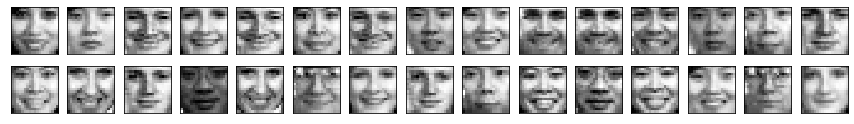

In [23]:

from IPython.display import Image
Image(filename='local/imgs/similar-images2.png')


In [27]:
def find_similar(v, X, n):
    from sklearn.decomposition import NMF

    nmf = NMF(n_components=30, init="random", random_state=0)
    nmf.fit(X)
    Xt = nmf.transform(X)
    vt = nmf.transform(v.reshape(1, -1))

    dists = np.linalg.norm(Xt - vt[0], axis=1)
    result = np.argsort(dists)[:n]

    return result

check manually your answer

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


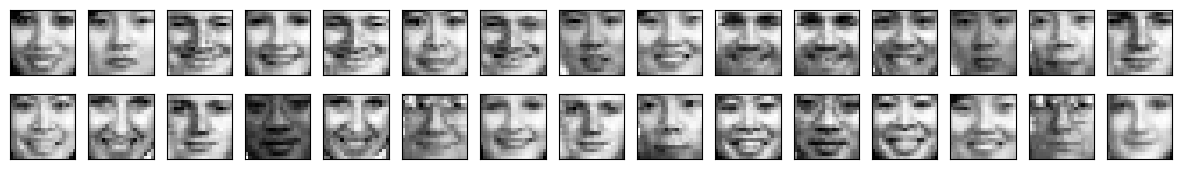

In [28]:

plot_faces(faces[find_similar(face, faces, 30)])


**submit your code**

In [29]:
student.submit_task(globals(), task_id="task_03");